In [ ]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

!wget -qO- https://github.com/DM-GY-9103-2024F-H/9103-utils/releases/latest/download/lfw.tar.gz | tar xz

In [12]:
import pandas as pd
import torch

from os import listdir, path
from sklearn.model_selection import train_test_split
from torch import nn, Tensor
from torch.nn.functional import relu
from torch.utils.data import DataLoader

from data_utils import PCA, StandardScaler
from data_utils import classification_error, display_confusion_matrix
from data_utils import LFWUtils

from image_utils import make_image, open_image

from HW12_utils import HW12Utils, FaceDataset

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
train, test = LFWUtils.train_test_split(0.5)

x_train = Tensor(train["pixels"])
y_train = Tensor(train["labels"]).long()

x_test = Tensor(test["pixels"])
y_test = Tensor(test["labels"]).long()

train_dataloader = DataLoader(FaceDataset(x_train, y_train), batch_size=128, shuffle=True)
test_dataloader = DataLoader(FaceDataset(x_test, y_test), batch_size=512)

## Try visualizing first layer output

In [ ]:
# Define custom class to specify output from first layer
class CustomModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomModel, self).__init__()
        # Define layers
        self.layer1 = nn.Linear(input_size, 128)  # Input to hidden layer
        self.relu = nn.ReLU()  # ReLU activation
        self.layer2 = nn.Linear(128, output_size)  # Hidden to output layer

    def forward(self, x):
        x1 = self.layer1(x)  # After first layer
        x2 = self.relu(x1)  # After ReLU activation
        output = self.layer2(x2)  # Final output
        return x1, x2, output 

In [ ]:
# Define the model
input_size = 22100
output_size = len(y_train.unique())
model = CustomModel(input_size, output_size)

img, label = next(iter(train_dataloader))
out = model(img)

# Train the model
learning_rate = 1e-7
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

for e in range(500):
  
  for imgs, labels in train_dataloader:
    optim.zero_grad()
    _, _, output = model(imgs)

    loss = loss_fn(output, labels)

    loss.backward()
    optim.step()

  if e % 100 == 9:
    print(f"Epoch: {e} loss: {loss.item():.4f}")

Epoch: 9 loss: 14.8611
Epoch: 109 loss: 3.0707
Epoch: 209 loss: 2.3616
Epoch: 309 loss: 2.3513
Epoch: 409 loss: 2.0995


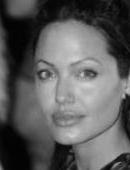

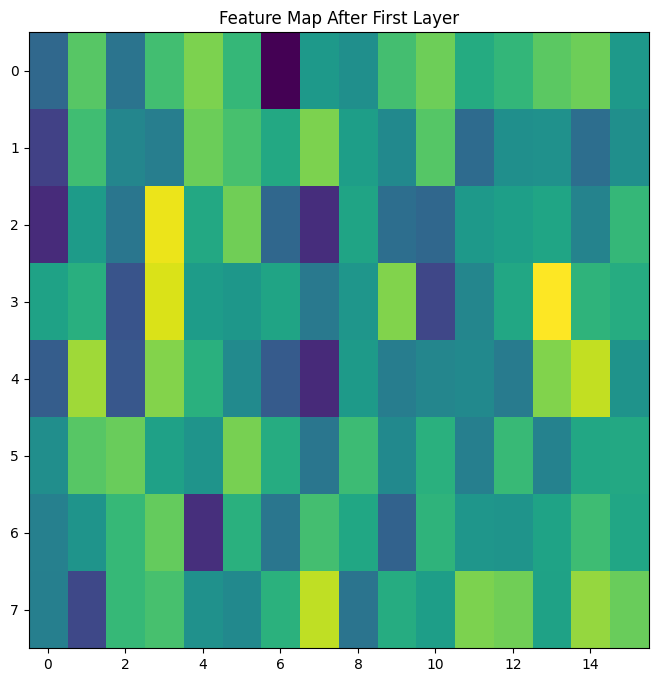

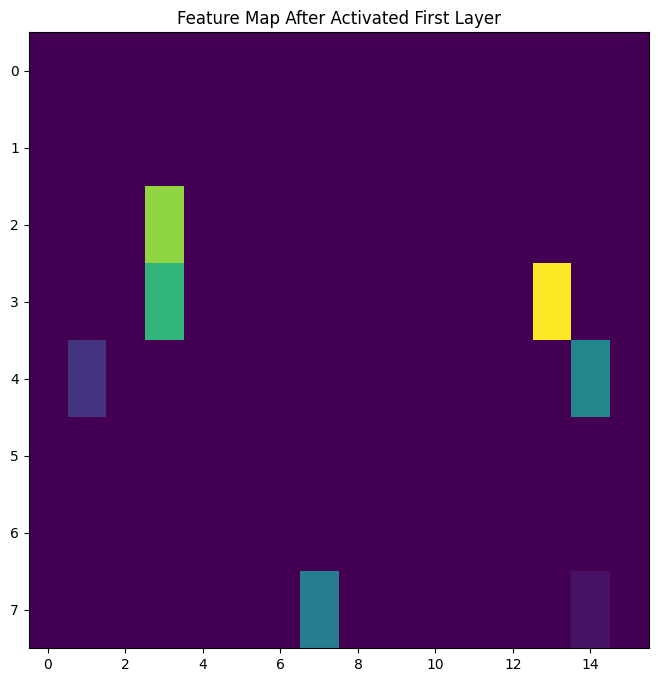

In [ ]:
# Load and preprocess the image
img_path = 'data/image/lfw/cropped/jolie/jolie-019.jpg'

img = Image.open(img_path)
img = img_to_array(img)  

# Normalize and flatten the image
img = img / 255.0  
img = img.flatten()  
img = torch.tensor(img).unsqueeze(0).float()  

# Pass the image through the model to get both the feature map and final output
x1, x2, _ = model(img) 

# Reshape the feature map to visualize it (e.g., 8x16 grid for 128 features)
x1 = x1.detach().numpy().reshape(8, 16)  
x2 = x2.detach().numpy().reshape(8, 16) 

# Visualize the feature map
Image.open(img_path).show()

plt.figure(figsize=(8, 8))
plt.imshow(x1, aspect='auto')
plt.title("Feature Map After First Layer")
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(x2, aspect='auto')
plt.title("Feature Map After Activated First Layer")
plt.show()

## Visualize sequence of first layer outputs for different epochs

In [ ]:
def visualize_layer(img_path, model, e):
    img = Image.open(img_path)
    img = img_to_array(img)  

    # Normalize and flatten the image
    img = img / 255.0  
    img = img.flatten()  
    img = torch.tensor(img).unsqueeze(0).float()  

    # Pass the image through the model to get both the feature map and final output
    x1, x2, _ = model(img)  

    # Reshape the feature map to visualize it (e.g., 8x16 grid for 128 features)
    x1 = x1.detach().numpy().reshape(8, 16)  
    x2 = x2.detach().numpy().reshape(8, 16)  

    # Visualize the feature map
    plt.figure(figsize=(8, 8))
    plt.imshow(x2, aspect='auto')
    plt.title("Epoch: " + str(e))
    plt.show()

Epoch: 0 loss: 58.0427


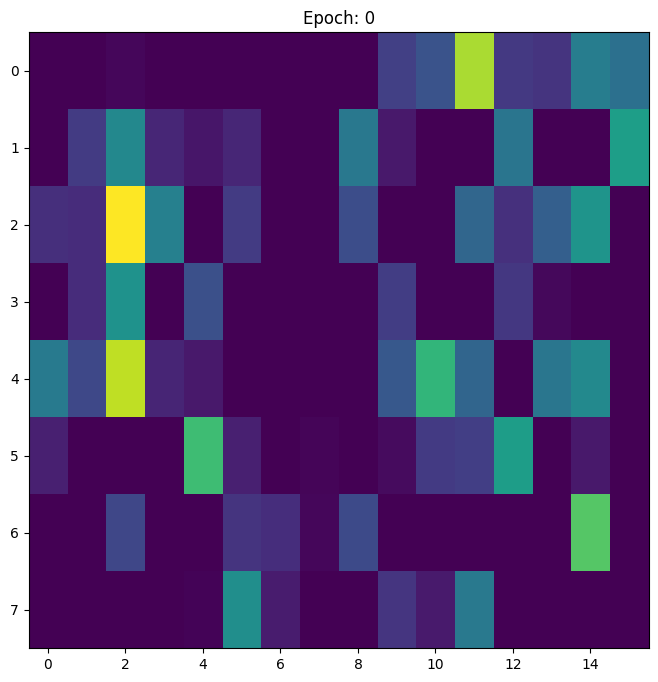

Epoch: 50 loss: 5.6142


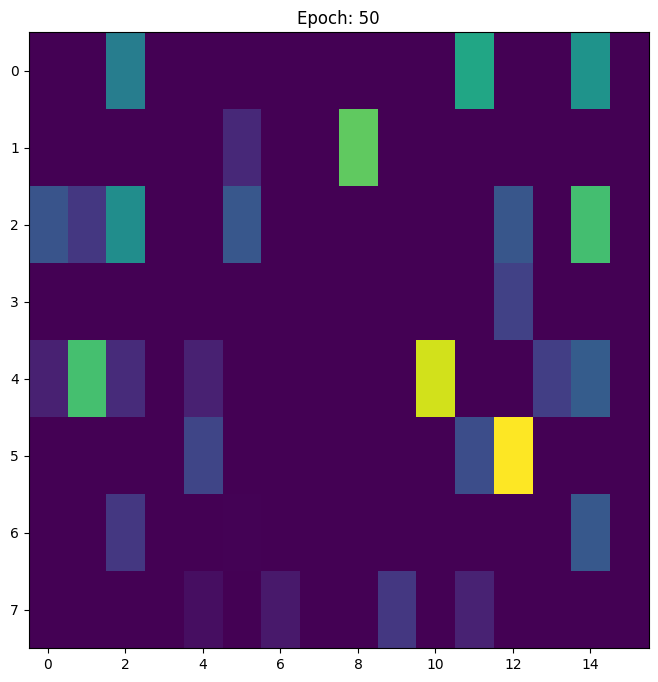

Epoch: 100 loss: 4.2531


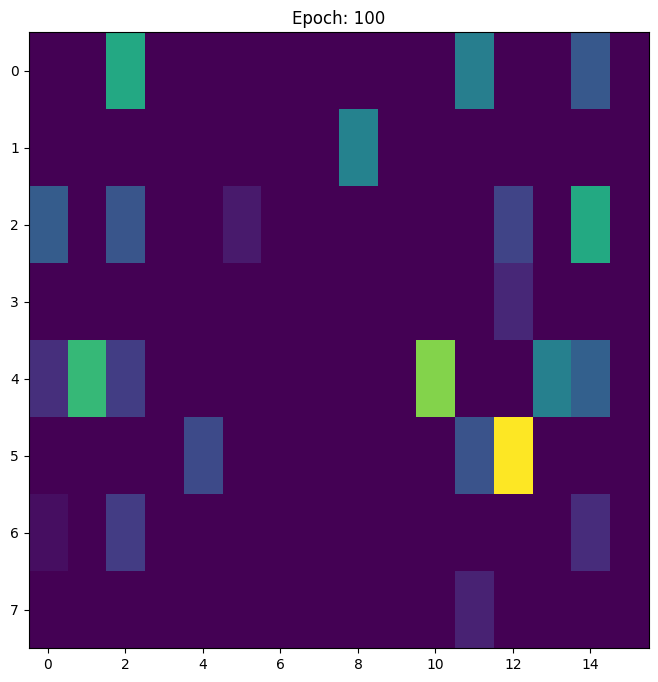

Epoch: 150 loss: 2.5494


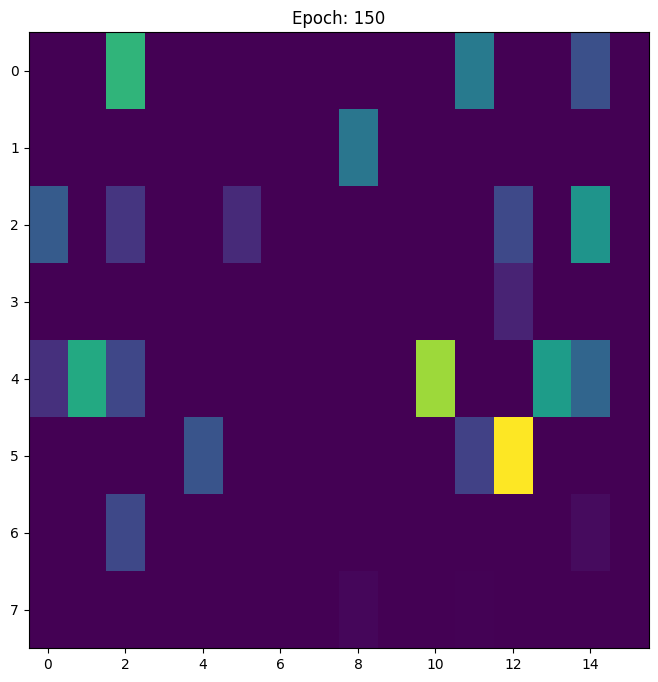

Epoch: 200 loss: 2.2828


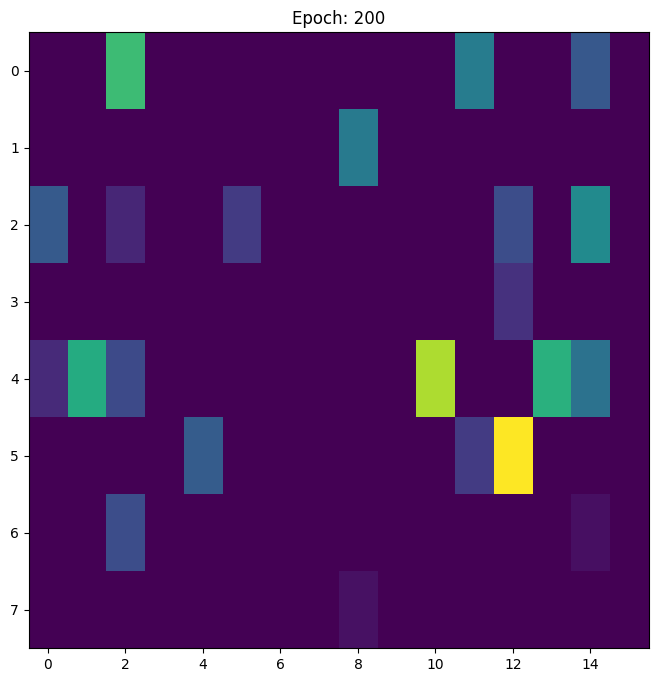

Epoch: 250 loss: 1.5213


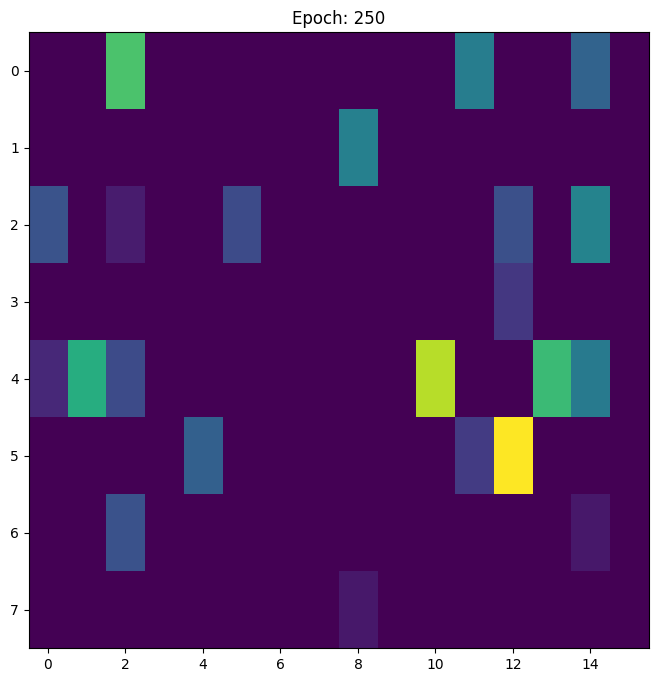

Epoch: 300 loss: 1.5718


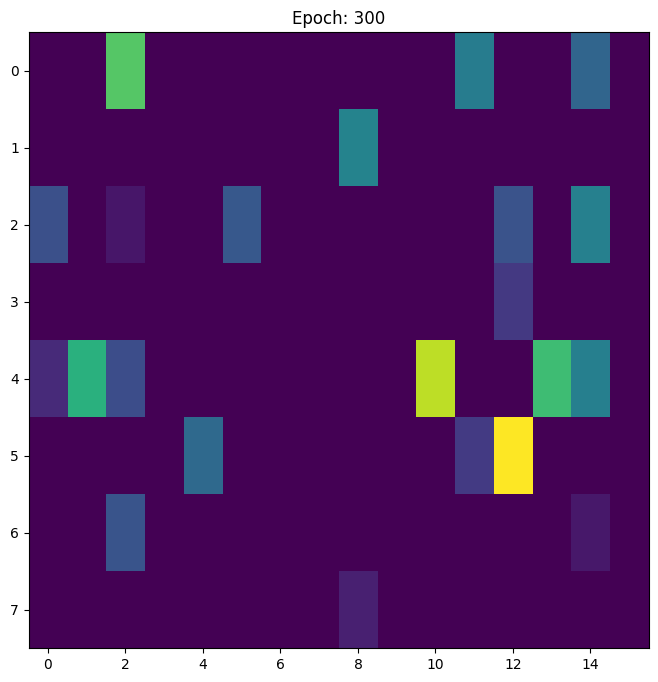

Epoch: 350 loss: 0.8505


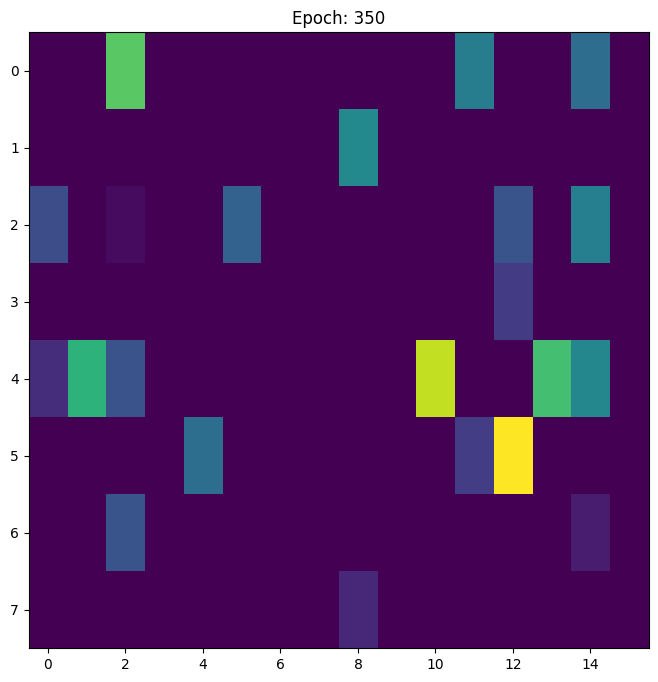

Epoch: 400 loss: 0.8602


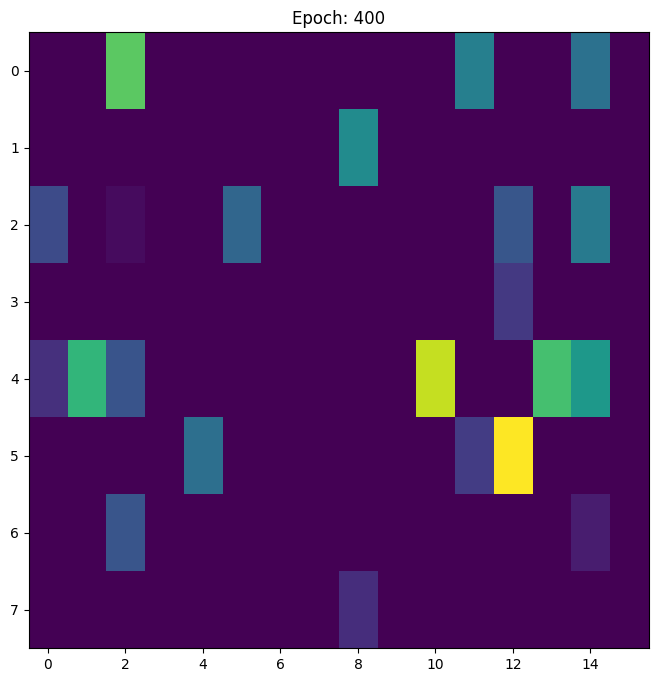

Epoch: 450 loss: 0.7938


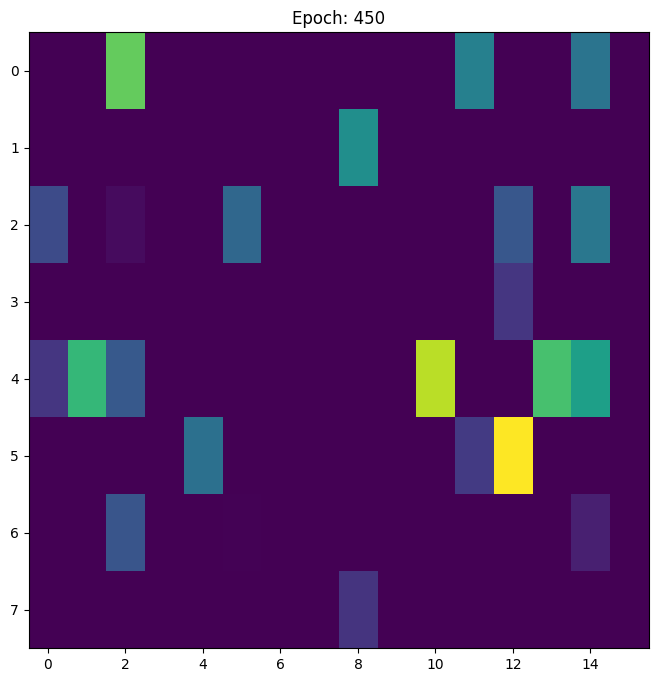

In [ ]:
# Define the model
input_size = 22100
output_size = len(y_train.unique())
model = CustomModel(input_size, output_size)
img_path = 'data/image/lfw/cropped/jolie/jolie-019.jpg'

img, label = next(iter(train_dataloader))
out = model(img)

# Train the model
learning_rate = 1e-7
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

for e in range(500):
  
  for imgs, labels in train_dataloader:
    optim.zero_grad()
    _, _, output = model(imgs)

    loss = loss_fn(output, labels)

    loss.backward()
    optim.step()

  # Visualize layer for each 50th epoch
  if e % 50 == 0:
    print(f"Epoch: {e} loss: {loss.item():.4f}")
    visualize_layer(img_path, model, e)